#### **Recurrent Neural Networks with Long Short Term Memory Units for Time Series Predictions and Imputations Test - 17 Nov**

1. Test on all Monday 24 hours data for Peachtree Street SB L1

In [1]:
!pip install tf-nightly-2.0-preview

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import os
import math
print(tf.__version__)

2.0.0-dev20191002


In [3]:
dataset = pd.read_csv('allmonday_reviseddata_modified.csv', header=0, index_col=None)

#replace missing values y -10 to test if model will learn to not include these in these as missing values
dataset_w_missing = dataset.fillna(-10,inplace=True)
dataset = dataset[:-240]
dataset=dataset[dataset['date_time'].str.contains("2/25/2019")==False]
#check
print (dataset.iloc[49]['State-EB-L_1'])
#print (dataset.iloc[3359]['State-EB-L_1'])

-10.0


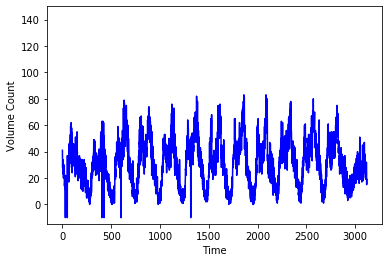

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("VolumeCount")
    plt.grid(False)

#extract State-EB-L_1 series 
series = dataset['Peachtree-SB-L_1'].values
time = dataset['date_time'].values

time_num = [i for i in range(len(series))]
plt.plot(time_num, series, color = 'blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.ylim(top=150)
plt.grid(False)

**Split data into training and time**

**Define window_size, batch_size, and shuffle_buffer_size for modelling**

Window Size

batch Size

Shuffle uffer Size

In [5]:
num_days = 10
split_time = num_days*240
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 100
batch_size = 30
shuffle_buffer_size = 100

**Creating windowed dataset**

Give explanation...



In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
os.environ['PYTHONHASHSEED']=str(52)
tf.keras.backend.clear_session()
tf.random.set_seed(52)
np.random.seed(52)
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


# model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 10.0)
# ])

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=150, callbacks=[lr_schedule])


In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 30])

In [ ]:
os.environ['PYTHONHASHSEED']=str(51)
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30)),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 100.0)
# ])

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=2e-6, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

In [ ]:
model.save('peachtree_sb_uni_l1-2.h5')


In [6]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('peachtree_sb_uni_l1-2.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 80)          33600     
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 80)          38720     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                28928     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0

(-2.95, 120)

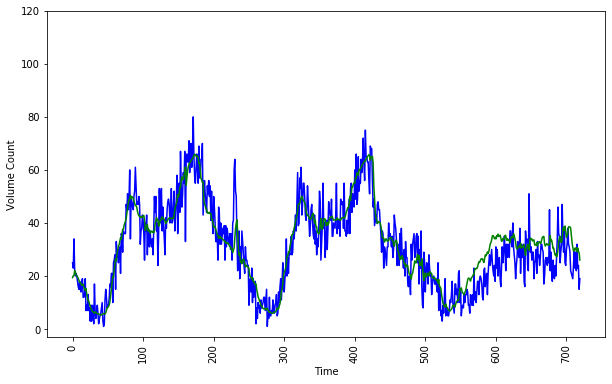

In [7]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(new_model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
#print (forecast)
results = np.array(forecast)[:, 0, 0]
time_valid = [i for i in range(len(time_valid))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_valid, x_valid, color = 'blue')
plt.plot(time_valid, results, color = 'green')
plt.ylim(top=120)
# plt.figure(figsize=(10, 6))
# plt.xticks(rotation=90)
# plot_series(time_valid, x_valid)
# plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.7400465

In [9]:
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

52.52808

In [10]:
# RMSE 
math.sqrt(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())


7.247625817229547

In [11]:
#Forecast bias
array_of_errors = (x_valid - results)
forecast_bias = sum(array_of_errors)
print (array_of_errors)
print (forecast_bias)

[ 5.58419228e+00  2.88703728e+00  1.37671318e+01 -6.28528595e-02
 -1.39265060e+00  5.95256805e-01 -1.03723526e-01 -1.73223495e+00
 -3.13289070e+00 -3.42953873e+00  3.15753937e-01 -2.60114479e+00
 -3.01923752e+00  1.54666138e+00  2.34537697e+00 -4.96067619e+00
 -3.91604805e+00 -2.12268257e+00  4.40171814e+00 -8.29336834e+00
 -4.39307308e+00 -5.12839985e+00  2.31870651e+00 -3.55715370e+00
 -1.43081093e+00 -5.67169380e+00  1.42551517e+00 -4.36217022e+00
  2.34513474e+00  1.52536678e+00 -4.30417585e+00  1.10660992e+01
  4.50654984e-01 -2.34375572e+00  1.42273903e-02  3.22698498e+00
  1.93203449e-01 -3.73519468e+00 -1.52762699e+00 -4.09610271e-01
  7.01078415e-01  2.66922474e+00  4.49849367e+00 -2.85228443e+00
 -4.80799866e+00 -3.78285980e+00  5.25733471e+00  8.88267040e+00
  4.92323494e+00  1.25407219e-01  8.51074219e-01  4.04391289e-01
  2.79361057e+00  6.49643135e+00  3.09059906e+00  6.15337849e+00
  3.41256523e+00 -9.88167191e+00  5.36217690e+00  3.75741959e+00
  3.62004471e+00 -1.15157

In [12]:
# Std. Dev. in Errors
np.std(array_of_errors)

7.145561898658027

In [13]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (x_valid - results)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 5.7400465
mean squared error: 52.52808
root mean squared error: 7.247625817229547
forecast_bias: -872.6641592979431
standard dev of errors: 7.145561898658027


## Forecast on Typical Day

In [14]:
typical_actuals = x_valid[:480]
typical_predictions = results[:480]
#print (typical_predictions)
mae = tf.keras.metrics.mean_absolute_error(typical_actuals, typical_predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(typical_actuals, typical_predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(typical_actuals, typical_predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (typical_actuals - typical_predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 5.254285
mean squared error: 46.082634
root mean squared error: 6.788419106991551
forecast_bias: 26.76554012298584
standard dev of errors: 6.788189948145301


(-2.95, 120)

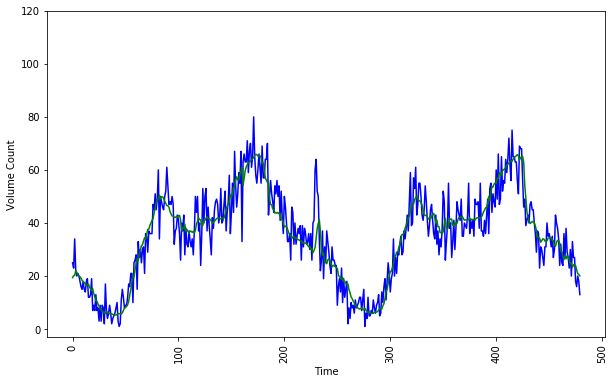

In [15]:
time_typical = [i for i in range(len(typical_actuals))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_typical, typical_actuals, color = 'blue')
plt.plot(time_typical, typical_predictions, color = 'green')
plt.ylim(top=120)

## Forecast on Atypical Day

In [16]:
atypical_actuals = x_valid[-240:]
atypical_predictions = results[-240:]
#print (atypical_predictions)

mae = tf.keras.metrics.mean_absolute_error(atypical_actuals, atypical_predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(atypical_actuals, atypical_predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(atypical_actuals, atypical_predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (atypical_actuals - atypical_predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 6.7115703
mean squared error: 65.418976
root mean squared error: 8.088199789203907
forecast_bias: -899.429699420929
standard dev of errors: 7.167586243509754


(0.5999999999999996, 120)

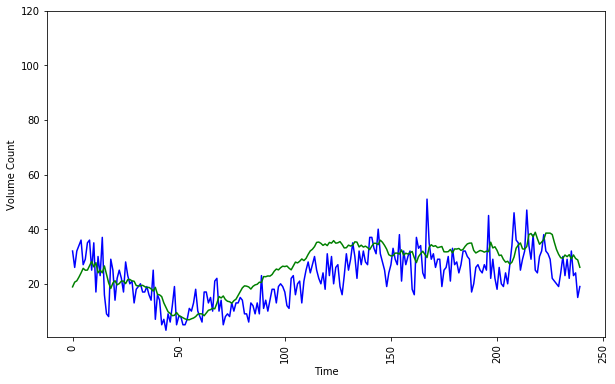

In [17]:
time_atypical = [i for i in range(len(atypical_actuals))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_atypical, atypical_actuals, color = 'blue')
plt.plot(time_atypical, atypical_predictions, color = 'green')
plt.ylim(top=120)

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

(-2.95, 150)

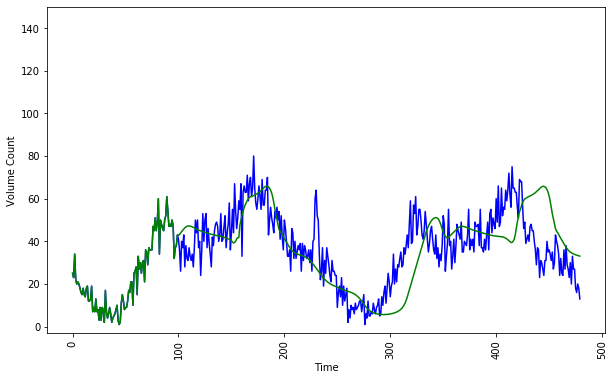

In [23]:
forecast = []
results = []

slice_val_time = 100
sliced_val_series = x_valid[:slice_val_time] 

#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
units_missing = 380
for t in range(units_missing):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    sliced_val_series = np.append(sliced_val_series, forecast[-1])


#forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
# print (results)
# print (sliced_val_series)
# plt.figure(figsize=(10, 6))
# plt.xticks(rotation=90)

sliced_val_actual = x_valid[:slice_val_time+units_missing] 
sliced_val_times = time_valid[:slice_val_time+units_missing]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual, color = 'blue')
plt.plot(sliced_val_times, sliced_val_series, color = 'green')
plt.ylim(top=150)

# plot_series(sliced_val_times, sliced_val_actual)
# plot_series(sliced_val_times, sliced_val_series)

In [24]:
tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()

8.466103220979372

In [25]:
mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (sliced_val_actual-sliced_val_series)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 8.466103220979372
mean squared error: 150.98901786714953
root mean squared error: 12.287758862670993
forecast_bias: -38.08140707015991
standard dev of errors: 12.28750274157643


In [31]:
actuals = sliced_val_actual[-380:]
print (actuals)
predictions = sliced_val_series[-380:]
print (predictions)

mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals - predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

[41. 36. 26. 40. 37. 43. 28. 38. 32. 31. 37. 33. 31. 34. 28. 37. 50. 44.
 50. 37. 40. 24. 36. 53. 40. 50. 53. 37. 46. 39. 34. 28. 42. 38. 45. 48.
 49. 47. 40. 43. 53. 40. 41. 47. 52. 37. 44. 48. 58. 36. 44. 55. 44. 67.
 54. 46. 51. 59. 55. 67. 33. 63. 66. 63. 63. 71. 59. 67. 70. 61. 65. 80.
 65. 58. 55. 60. 66. 61. 55. 69. 57. 57. 64. 64. 70. 43. 50. 56. 51. 48.
 44. 54. 51. 56. 50. 54. 41. 52. 42. 36. 50. 46. 40. 33. 33. 36. 26. 46.
 44. 32. 40. 32. 35. 38. 36. 39. 26. 39. 31. 38. 36. 32. 33. 36. 30. 36.
 26. 40. 41. 60. 64. 52. 50. 34. 22. 26. 37. 19. 31. 25. 37. 33. 29. 24.
 21. 31. 26. 26. 24. 24.  9. 16. 19. 14. 23. 10. 19. 12. 15. 18.  2.  8.
  4. 10.  8.  9.  6. 11.  8.  9. 10. 12. 12.  7. 11. 15.  1.  6.  4. 12.
  5.  5.  7.  6. 11.  8.  6.  9. 10. 13.  5.  6. 14. 10. 16. 19. 11. 18.
 25. 21. 14. 19. 21. 34. 20. 27. 21. 29. 28. 32. 35. 28. 29. 37. 34. 38.
 43. 37. 48. 59. 39. 40. 57. 53. 61. 43. 47. 55. 55. 50. 43. 41. 45. 54.
 48. 41. 35. 39. 45. 47. 41. 36. 34. 43. 32. 37. 28

## Different Time Slice

In [40]:
forecast = []
results = []
mae_array = []
rmse_array = []
std_array = []

for slice_val_time in range(100,351,10):
    #slice_val_time = 630
    sliced_val_series = x_valid[:slice_val_time] 

    #forecasts only on validation part of time series
    #series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
    units_missing = 120
    for t in range(units_missing):
        l=len(sliced_val_series)
        #print (sliced_val_series[(l-window_size):l])
        forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
        sliced_val_series = np.append(sliced_val_series, forecast[-1])


    #forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    # print (results)
    # print (sliced_val_series)
    # plt.figure(figsize=(10, 6))
    # plt.xticks(rotation=90)

    sliced_val_actual = x_valid[:slice_val_time+units_missing] 
    sliced_val_times = time_valid[:slice_val_time+units_missing]

    sliced_val_times = [i for i in range(len(sliced_val_times))]
    actuals_slice = sliced_val_actual[-units_missing:]
    predictions_slice = sliced_val_series[-units_missing:]

    mae = tf.keras.metrics.mean_absolute_error(actuals_slice, predictions_slice).numpy()
    print ("mean absolute error: "+ str(mae))
    mae_array.append(mae)
    mse = tf.keras.metrics.mean_squared_error(actuals_slice, predictions_slice).numpy()
    print ("mean squared error: "+ str(mse))
    rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals_slice, predictions_slice).numpy())
    print ("root mean squared error: "+ str(rmse))
    rmse_array.append(rmse)
    array_of_errors = (actuals_slice - predictions_slice)
    forecast_bias = sum(array_of_errors)
    #print (array_of_errors)
    print ("forecast_bias: "+ str(forecast_bias))
    std_dev_errors = np.std(array_of_errors)
    print ("standard dev of errors: "+ str(std_dev_errors))
    std_array.append(std_dev_errors)

mean absolute error: 7.472213427225749
mean squared error: 85.8204060404137
root mean squared error: 9.263930377567272
forecast_bias: -80.5076675415039
standard dev of errors: 9.239605129433082
mean absolute error: 7.170190223058065
mean squared error: 85.9003080477614
root mean squared error: 9.268241907058824
forecast_bias: 313.6989040374756
standard dev of errors: 8.891933897473889
mean absolute error: 8.234132846196493
mean squared error: 123.59864251248027
root mean squared error: 11.117492636043448
forecast_bias: 496.9719409942627
standard dev of errors: 10.317324097402437
mean absolute error: 8.557406346003214
mean squared error: 129.2591984330299
root mean squared error: 11.369221540326755
forecast_bias: 597.1752758026123
standard dev of errors: 10.222232535717676
mean absolute error: 8.439718182881673
mean squared error: 127.55847090409436
root mean squared error: 11.29417862901479
forecast_bias: 593.0658416748047
standard dev of errors: 10.155440825739923
mean absolute error:

In [41]:
print (mae_array)
print (rmse_array)
print (std_array)

[7.472213427225749, 7.170190223058065, 8.234132846196493, 8.557406346003214, 8.439718182881673, 7.976441518465678, 7.3877794941266375, 6.762068299452464, 7.127583571275076, 7.70683661699295, 8.46806956132253, 9.143613024552662, 9.674694104989369, 13.23887312412262, 14.43224207162857, 16.827131537596383, 11.75715386470159, 7.33093398809433, 7.6813472231229145, 6.3921943267186485, 6.547196992238363, 7.121390056610108, 7.927062066396077, 8.364750194549561, 8.628109327952068, 5.7591719150543215]
[9.263930377567272, 9.268241907058824, 11.117492636043448, 11.369221540326755, 11.29417862901479, 10.847350033684233, 10.27361646955624, 9.570768241398282, 9.913610996476699, 10.560225776060973, 11.456503829446287, 12.169784240064022, 12.842985761893356, 17.527066174469738, 18.93265521076392, 21.484000849104333, 15.13203566658031, 8.957514279066562, 9.276903427110842, 7.946120312616251, 7.905989428463458, 8.972287466231673, 9.852962523516267, 10.395439066511765, 10.804136292765538, 7.19272171977632

## Moving Average Method

In [ ]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

In [ ]:
moving_avg = moving_average_forecast(series, window_size)[split_time - window_size:]

time_valid = [i for i in range(len(time_valid))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_valid, x_valid, color = 'blue')
plt.plot(time_valid, moving_avg, color = 'green')
plt.ylim(top=150)

# plt.figure(figsize=(10, 6))
# plot_series(time_valid, x_valid)
# plot_series(time_valid, moving_avg)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

In [ ]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (x_valid - moving_avg)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

In [ ]:
forecast = []
results = []

slice_val_time = 480
sliced_val_series = x_valid[:slice_val_time] 

print (len(sliced_val_series))
# x_val = series[split_time-window_size:]
#sliced_val_series =x_valid

#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
units_missing = 240
for t in range(units_missing):
    #forecast.append(series[time:time + window_size].mean())
    #print (t)
    forecast.append(sliced_val_series[t:t + window_size].mean())
    sliced_val_series = np.append(sliced_val_series, forecast[-1])
#     l=len(sliced_val_series)
#     print (l)
#     forecast.append(moving_average_forecast(sliced_val_series, window_size))
#     #print (sliced_val_series[(l-window_size):l])
#     #forecast.append(model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
#     sliced_val_series = np.append(sliced_val_series, forecast[-1])

#print (forecast)
# #forecast = forecast[split_time-window_size:]
# #results = np.array(forecast)[:, 0, 0]
# # print (results)
#print (sliced_val_series)
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)

sliced_val_actual = x_valid[:slice_val_time+units_missing] 
sliced_val_times = time_valid[:slice_val_time+units_missing]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual, color = 'blue')
plt.plot(sliced_val_times, sliced_val_series, color = 'green')
plt.ylim(top=150)

# plot_series(sliced_val_times, sliced_val_actual)
# plot_series(sliced_val_times, sliced_val_series)

In [ ]:
tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()

In [ ]:
mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (sliced_val_actual - sliced_val_series)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

## Model Performance on 18th March for Simulation Experiment

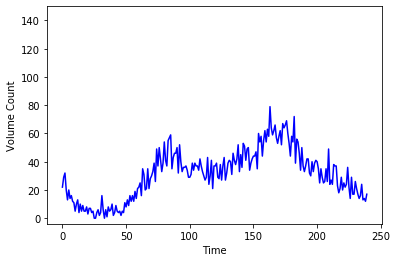

In [32]:
## Load the orginal csv 
dataset_orginal = pd.read_csv('allmonday_reviseddata.csv', header=0, index_col=None)

## Infill nan with -10 
dataset_original_w_missing = dataset_orginal.fillna(-10,inplace=True)
dataset_original = dataset_orginal[:-240]
dataset_original=dataset_original[dataset_original['date_time'].str.contains("3/18/2019")==True]
#print (dataset_original)
#extract State-EB-L_1 series for 18th March
series_18march = dataset_original['Peachtree-SB-L_1'].values
time_18march = dataset_original['date_time'].values

time_num_18march = [i for i in range(len(series_18march))]

# Plot the 18th March data
plt.plot(time_num_18march, series_18march, color = 'blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.ylim(top=150)
plt.grid(False)

(-3.95, 150)

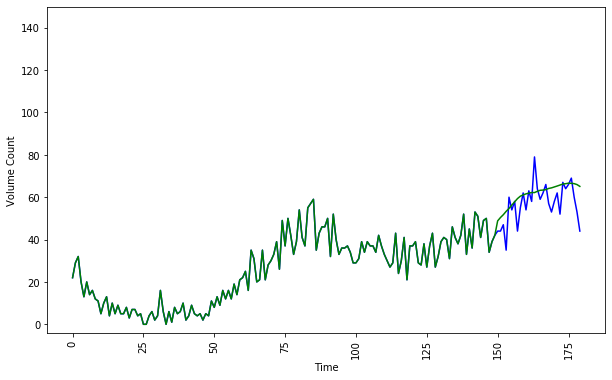

In [33]:
##apply model to the 18th march data
forecast = []
results = []

slice_val_time = 150
sliced_val_series = series_18march[:slice_val_time] 

#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
units_missing = 30
for t in range(units_missing):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    sliced_val_series = np.append(sliced_val_series, forecast[-1])


#forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
# print (results)
# print (sliced_val_series)

sliced_val_actual = series_18march[:slice_val_time+units_missing] 
sliced_val_times = time_18march[:slice_val_time+units_missing]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual, color = 'blue')
plt.plot(sliced_val_times, sliced_val_series, color = 'green')
plt.ylim(top=150)

In [38]:
print (sliced_val_actual)
print (sliced_val_series)
actuals = sliced_val_actual[-units_missing:]
predictions = sliced_val_series [-units_missing:]

mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals-predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

[22. 29. 32. 20. 13. 20. 14. 16. 12. 11.  5. 10. 13.  4. 10.  5.  9.  5.
  5.  8.  3.  7.  7.  4.  5.  0.  0.  4.  6.  2.  4. 16.  6.  0.  6.  1.
  8.  5.  6. 10.  2.  4.  9.  5.  4.  5.  2.  5.  4. 11.  8. 13.  9. 16.
 12. 16. 12. 19. 14. 21. 22. 25. 16. 35. 31. 20. 21. 35. 21. 28. 30. 33.
 39. 26. 49. 37. 50. 42. 33. 39. 54. 41. 37. 55. 57. 59. 35. 43. 46. 46.
 50. 32. 52. 40. 33. 36. 36. 37. 34. 29. 29. 31. 39. 34. 39. 37. 37. 34.
 42. 37. 33. 30. 27. 29. 43. 24. 30. 41. 21. 37. 37. 39. 29. 28. 38. 27.
 37. 43. 27. 32. 39. 41. 40. 31. 46. 41. 38. 42. 52. 33. 45. 36. 53. 51.
 41. 49. 50. 34. 39. 42. 44. 44. 47. 35. 60. 54. 58. 44. 55. 62. 54. 63.
 58. 79. 64. 59. 62. 66. 57. 53. 58. 62. 52. 67. 64. 66. 69. 60. 53. 44.]
[22.         29.         32.         20.         13.         20.
 14.         16.         12.         11.          5.         10.
 13.          4.         10.          5.          9.          5.
  5.          8.          3.          7.          7.          4.
  5.     

In [ ]:
## Store actual and predicted values in csv
pd.DataFrame(sliced_val_actual).to_csv("actual_peachtree_sb_l1_univariate_18mar.csv")
pd.DataFrame(sliced_val_series).to_csv("predicted_peachtree_sb_l1_univariate_18mar.csv")

## Model Performance on 27 May (Memorial Day) for Simulation Experiment

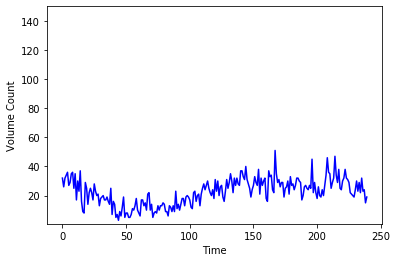

In [39]:
## Load the orginal csv 
dataset_orginal = pd.read_csv('allmonday_reviseddata_modified.csv', header=0, index_col=None)

## Infill nan with -10 
dataset_original_w_missing = dataset_orginal.fillna(-10,inplace=True)
dataset_original = dataset_orginal[:-240]
dataset_original=dataset_original[dataset_original['date_time'].str.contains("5/27/2019")==True]

#extract State-EB-L_1 series for 18th March
series_5may = dataset_original['Peachtree-SB-L_1'].values
time_5may = dataset_original['date_time'].values

time_num_5may = [i for i in range(len(series_5may))]

# Plot the 18th March data
plt.plot(time_num_5may, series_5may, color = 'blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.ylim(top=150)
plt.grid(False)

(0.5999999999999996, 150)

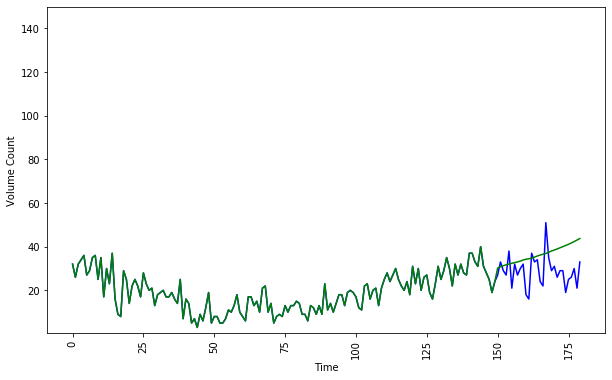

In [40]:
##apply model to the 27th may data
forecast = []
results = []

slice_val_time = 150
sliced_val_series = series_5may[:slice_val_time] 

#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
units_missing = 30
for t in range(units_missing):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    sliced_val_series = np.append(sliced_val_series, forecast[-1])


#forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
# print (results)
# print (sliced_val_series)

sliced_val_actual = series_5may[:slice_val_time+units_missing] 
sliced_val_times = time_5may[:slice_val_time+units_missing]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual, color = 'blue')
plt.plot(sliced_val_times, sliced_val_series, color = 'green')
plt.ylim(top=150)

In [41]:
print (sliced_val_actual)
print (sliced_val_series)
actuals = sliced_val_actual[-units_missing:]
predictions = sliced_val_series [-units_missing:]

mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals-predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))


# mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()
# print ("mean absolute error: "+ str(mae))
# mse = tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy()
# print ("mean squared error: "+ str(mse))
# rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy())
# print ("root mean squared error: "+ str(rmse))
# array_of_errors = (sliced_val_actual-sliced_val_series)
# forecast_bias = sum(array_of_errors)
# #print (array_of_errors)
# print ("forecast_bias: "+ str(forecast_bias))
# std_dev_errors = np.std(array_of_errors)
# print ("standard dev of errors: "+ str(std_dev_errors))

[32. 26. 32. 34. 36. 27. 29. 35. 36. 25. 35. 17. 30. 23. 37. 16.  9.  8.
 29. 25. 14. 22. 25. 22. 17. 28. 23. 20. 21. 13. 18. 19. 20. 17. 17. 19.
 16. 14. 25.  7. 16. 14.  5.  7.  3.  9.  6. 12. 19.  5.  8.  8.  5.  5.
  7. 11. 10. 13. 18. 10.  8.  6. 17. 17. 13. 15. 10. 21. 22. 10. 14.  5.
  8.  9.  8. 13. 10. 13. 13. 15. 14.  9.  9.  6. 13. 12.  9. 13.  9. 23.
 11. 14. 10. 14. 18. 18. 13. 19. 20. 19. 17. 12. 11. 22. 23. 16. 20. 21.
 13. 21. 25. 28. 24. 27. 30. 25. 22. 20. 24. 18. 31. 23. 30. 20. 26. 27.
 19. 16. 23. 31. 25. 29. 35. 30. 22. 32. 27. 32. 28. 27. 37. 37. 33. 31.
 40. 31. 28. 25. 19. 24. 27. 33. 29. 27. 38. 21. 32. 27. 30. 32. 18. 16.
 37. 33. 34. 24. 22. 51. 35. 29. 31. 26. 29. 29. 19. 25. 26. 30. 21. 33.]
[32.         26.         32.         34.         36.         27.
 29.         35.         36.         25.         35.         17.
 30.         23.         37.         16.          9.          8.
 29.         25.         14.         22.         25.         22.
 17.     

In [ ]:
## Store actual and predicted values in csv
pd.DataFrame(sliced_val_actual).to_csv("actual_peachtree_sb_l1_univariate_27may.csv")
pd.DataFrame(sliced_val_series).to_csv("predicted_peachtree_sb_l1_univariate_27may.csv")